In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
words = open("./names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = { s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = { i:s for s,i in stoi.items() }
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(words)
n8 = int(0.8 * len(words))
n9 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n8])
Xde, Yde = build_dataset(words[n8:n9])
Xte, Yte = build_dataset(words[n9:])

print(Xtr.shape, Ytr.shape)
print(Xde.shape, Yde.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [ C, W1, b1, W2, b2 ]

In [8]:
print(sum( p.nelement() for p in parameters ))

11897


In [9]:
for p in parameters:
    p.requires_grad = True

In [10]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [11]:
# lri = []
lossi = []
stepsi = []

In [12]:
for k in range(200000):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh( emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None # zero'ing out grad
    loss.backward()
    
    # update params
    lr = 0.1 if k < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    lossi.append(loss.item())
    stepsi.append(k)

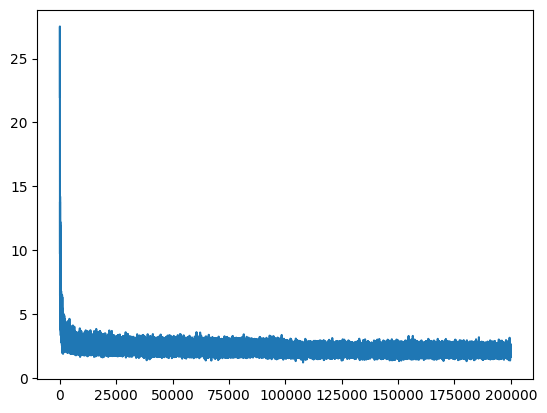

In [13]:
plt.plot(stepsi, lossi)

In [14]:
def calc_loss(split):
    X, Y = {
        "train": (Xtr, Ytr),
        "dev": (Xde, Yde),
        "test": (Xte, Yte)
    }[split]
    emb = C[X]
    h = torch.tanh( emb.view(-1, 30) @ W1 + b1 )
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())
    
calc_loss("train")
calc_loss("dev")
calc_loss("test")

train 2.1157407760620117
dev 2.157616138458252
test 2.1606907844543457


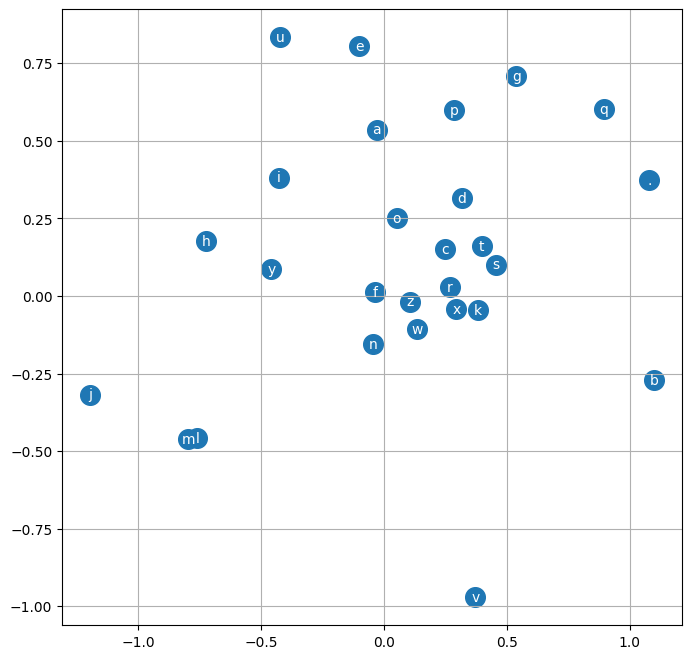

In [15]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")


In [16]:
g = torch.Generator().manual_seed(2147483647 + 10)

n_emb = 10

for _ in range(20):
    
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, 10)
        h = torch.tanh( emb.view(-1, n_emb * block_size) @ W1 + b1 )
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ix == 0:
            break
        context = context[1:] + [ix]
        out.append(itos[ix])
    
    print(''.join(out))

carmah
amelle
khi
mili
taty
skcassie
mahnel
delynn
jareen
nellara
chaiiv
kaleigh
ham
pris
quinn
sulin
alian
quinathon
jarynix
kaellinslee
